In [1]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

import tempfile
logdir = tempfile.mkdtemp()
print logdir

/var/folders/r4/71xfppdj0298vd08dyvq74h40000gn/T/tmp3hkd8x


In [2]:
b = tf.Variable(tf.zeros((100,)))
W = tf.Variable(tf.random_uniform((784, 100),
                -1, 1))

x = tf.placeholder(tf.float32, (None, 784), name="x")
h_i = tf.nn.relu(tf.matmul(x, W) + b)

---------------------------------

## Linear regression example

(Mostly stolen from https://github.com/nlintz/TensorFlow-Tutorials/blob/master/1_linear_regression.py)

In [3]:
tf.ops.reset_default_graph()

Our target data is generated by $y = 2x + \epsilon$, where $\epsilon \sim \mathcal N(0, \sigma^2)$.

In [4]:
x_batch = np.linspace(-1, 1, 101)
y_batch = x_batch * 2 + np.random.randn(*x_batch.shape) * 0.3

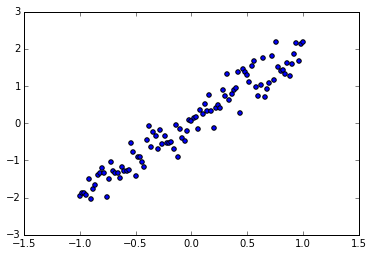

In [5]:
plt.scatter(x_batch, y_batch)

Add placeholder nodes to our graph for input values $x$ and targets $y$. The only required argument to `tf.placeholder` is the datatype specification.

The second argument `shape=(None,)` indicates that these variables take on a 1-dimensional value of a *dynamic* size. We can use the `None` value in this case to allow for arbitrary batch sizes.

In [6]:
x = tf.placeholder(tf.float32, shape=(None,), name="x")
y = tf.placeholder(tf.float32, shape=(None,), name="y")

Build a weight variable $w$ and provide an initial value. This initial value can be a tensor or some value convertible to a tensor (e.g. a numpy `ndarray`).

In [7]:
w = tf.Variable(np.random.normal(), name="W")

Use the weight $w$ to predict a value $\hat y$ given a symbolic value $x$.

In [8]:
y_pred = tf.mul(w, x)

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

We can plot the predictions of the model before training:

In [10]:
y_pred_batch = sess.run(y_pred, {x: x_batch})

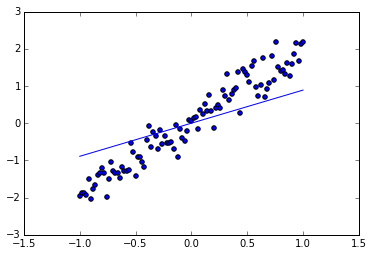

In [11]:
plt.figure(1)
plt.scatter(x_batch, y_batch)
plt.plot(x_batch, y_pred_batch)

Now let's define a cost function (MSE) and begin training.

In [12]:
cost = tf.reduce_mean(tf.square(y_pred - y))

Register a summary op which logs observed cost values.

In [13]:
summary_op = tf.scalar_summary("cost", cost)

Now define the optimization process.

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(cost)

Finally, prepare a summary writer instance. (Think of this as a logger.)

We provide the current graph structure as a second argument. This structure can be visualized in TensorBoard, which reads from the summary writer's output.

In [15]:
summary_writer = tf.train.SummaryWriter(logdir, sess.graph_def)

In [16]:
for t in range(30):
    cost_t, summary, _ = sess.run([cost, summary_op, train_op], {x: x_batch, y: y_batch})
    summary_writer.add_summary(summary, t)
    print cost_t.mean()

0.476454
0.42598
0.382137
0.344053
0.310973
0.282239
0.25728
0.2356
0.216768
0.20041
0.186201
0.173859
0.163138
0.153826
0.145737
0.138711
0.132608
0.127307
0.122702
0.118702
0.115228
0.11221
0.109589
0.107312
0.105334
0.103616
0.102123
0.100827
0.099701
0.0987229


In [17]:
y_pred_batch = sess.run(y_pred, {x: x_batch})

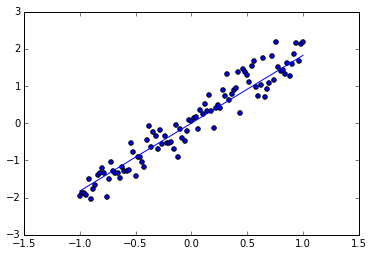

In [18]:
plt.figure(1)
plt.scatter(x_batch, y_batch)
plt.plot(x_batch, y_pred_batch)

In [19]:
summary_writer.flush()

## Sequence autoencoder

Because the obvious next step after learning about linear regression is to do sequence autoencoding.

While the sequence autoencoder is much more conceptually complex, it is still quick to implement and understand in TensorFlow. This is thanks to several good abstractions, most notably the `seq2seq` library in `tensorflow.models.rnn`.

(Note that `seq2seq` is not yet part of the public API.)

In [20]:
from tensorflow.models.rnn import rnn_cell, seq2seq

In [21]:
tf.ops.reset_default_graph()
sess = tf.InteractiveSession()

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10b7a9a50>> ignored


In [22]:
seq_length = 5
batch_size = 64

vocab_size = 7
embedding_dim = 50

memory_dim = 100

First build input placeholders and constants. The `seq2seq` API generally deals with lists of tensors, where each tensor represents a single timestep. An input to an embedding encoder, for example, would be a list of `seq_length` tensors, each of which is of dimension `batch_size` (specifying the embedding indices to input at a particular timestep).

We allocate a `labels` placeholder using the same convention. A `weights` constant specifies cross-entropy weights for each label at each timestep.

In [24]:
enc_inp = [tf.placeholder(tf.int32, shape=(None,),
                          name="inp%i" % t)
           for t in range(seq_length)]

labels = [tf.placeholder(tf.int32, shape=(None,),
                        name="labels%i" % t)
          for t in range(seq_length)]

weights = [tf.ones_like(labels_t, dtype=tf.float32)
           for labels_t in labels]

# Decoder input: prepend some "GO" token and drop the final
# token of the encoder input
dec_inp = ([tf.zeros_like(enc_inp[0], dtype=np.int32, name="GO")]
           + enc_inp[:-1])

# Initial memory value for recurrence.
prev_mem = tf.zeros((batch_size, memory_dim))

Build the sequence-to-sequence graph.

There is a **lot** of complexity hidden in these two calls, and it's certainly worth digging into both in order to really understand how this is working.

In [25]:
cell = rnn_cell.GRUCell(memory_dim)

dec_outputs, dec_memory = seq2seq.embedding_rnn_seq2seq(
    enc_inp, dec_inp, cell, vocab_size, vocab_size)

Build a standard sequence loss function: mean cross-entropy over each item of each sequence.

In [26]:
loss = seq2seq.sequence_loss(dec_outputs, labels, weights, vocab_size)

In [27]:
summary_op = tf.scalar_summary("loss", loss)

In [28]:
learning_rate = 0.05
momentum = 0.9
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
train_op = optimizer.minimize(loss)

In [29]:
logdir = tempfile.mkdtemp()
print logdir
summary_writer = tf.train.SummaryWriter(logdir, sess.graph_def)

/var/folders/r4/71xfppdj0298vd08dyvq74h40000gn/T/tmp8J9C7S


In [30]:
sess.run(tf.initialize_all_variables())

In [31]:
def train_batch(batch_size):
    X = [np.random.choice(vocab_size, size=(seq_length,), replace=False)
         for _ in range(batch_size)]
    Y = X[:]
    
    # Dimshuffle to seq_len * batch_size
    X = np.array(X).T
    Y = np.array(Y).T

    feed_dict = {enc_inp[t]: X[t] for t in range(seq_length)}
    feed_dict.update({labels[t]: Y[t] for t in range(seq_length)})

    _, loss_t, summary = sess.run([train_op, loss, summary_op], feed_dict)
    return loss_t, summary

In [32]:
for t in range(1000):
    loss_t, summary = train_batch(batch_size)
    summary_writer.add_summary(summary, t)
summary_writer.flush()

### Basic autoencoder test

In [35]:
X_batch = [np.random.choice(vocab_size, size=(seq_length,), replace=False)
           for _ in range(10)]
X_batch = np.array(X_batch).T

feed_dict = {enc_inp[t]: X_batch[t] for t in range(seq_length)}
dec_outputs_batch = sess.run(dec_outputs, feed_dict)

In [40]:
X_batch

array([[3, 2, 5, 0, 5, 5, 2, 3, 4, 5],
       [6, 1, 0, 5, 3, 3, 6, 2, 6, 2],
       [5, 0, 3, 3, 6, 4, 4, 6, 5, 4],
       [2, 5, 6, 6, 2, 6, 5, 5, 3, 3],
       [0, 4, 4, 4, 0, 1, 0, 0, 1, 6]])

In [39]:
[logits_t.argmax(axis=1) for logits_t in dec_outputs_batch]

[array([3, 2, 5, 0, 5, 5, 2, 3, 4, 5]),
 array([6, 1, 0, 5, 3, 3, 6, 2, 6, 2]),
 array([5, 0, 3, 3, 6, 4, 4, 6, 5, 4]),
 array([2, 5, 6, 6, 2, 6, 5, 5, 3, 3]),
 array([0, 4, 4, 4, 0, 1, 0, 0, 1, 6])]